# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [36]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import gc
import pickle as pkl

# Data manipulation
import numpy as np
import numpy.polynomial.chebyshev as cheb
from numpy.polynomial.chebyshev import chebfit, chebval
from scipy.optimize import curve_fit
from scipy.special import erf, erfinv, gamma
import scipy.stats as stats
from scipy.integrate import quad
from scipy.interpolate import CubicSpline, interpolate
from scipy.signal import savgol_filter
from scipy import fftpack
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
import matplotlib.pylab as plb

# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
import alens_analysis.chromatin.chrom_poly_stats as cps
import alens_analysis.helpers as ahlp
from alens_analysis import cluster_analysis as cla

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'
cond_path = Path.home() / 'ceph/DATA/Chromatin/CondCharPaper'

import warnings
warnings.filterwarnings('ignore')

cuda


### Style settings

In [3]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)
        

# Functions

In [4]:
def get_param_stats(h5_path, param_ind=0):
    with h5py.File(h5_path, 'r') as h5d:
        param = h5d.attrs['param']

        # Store parameter values and associated graphing colors
        param_val = sorted(list(h5d.keys()), key=lambda x: float(x))[1]
         
        h5_data = h5d[param_val]
        avg_clps_time = np.mean(h5_data.attrs['collapse_times'])
        std_clps_time = np.std(h5_data.attrs['collapse_times'])
        rog_avg = np.mean(h5_data.attrs['avg_collapse_rog'])
        rog_std = np.std(h5_data.attrs['avg_collapse_rog'])
        return avg_clps_time , std_clps_time, rog_avg, rog_std 


In [5]:
def save_msd_run_data(run_path, param_str, 
                    ss_ind = 1, end_ind = -1,
                    start_bead = 0, end_bead = None,
                  ):
    # Make analysis directory if it doesn't exist
    anal_path = (run_path / 'analysis')
    anal_path.mkdir(exist_ok=True)


    # Create an hdf5 file
    h5_path = anal_path / 'msd_run_data.h5'
    if h5_path.exists():
        h5_path.unlink()
    h5_file = h5py.File(h5_path, 'w')

    # Add label string as attribute
    h5_file.attrs['param'] = param_str

    sim_path = run_path / 'simulations'
    try:
        mp = re.compile(f'{param_str}(\d*\.?\d+)')
        param_dirs = sorted(
            [pd for pd in sim_path.glob('*/')],
            key=lambda x: float(mp.match(str(x.name))[1]))

    
        for i, pd in tqdm(enumerate(param_dirs)):
            msd_list = []
            sd_h5_data_lst = []
            for h5p in pd.glob('s*/analysis/raw*.h5'):
                try:
                    sd_h5_data_lst += [h5py.File(h5p, 'r')]
                except:
                    print(f'Could not open {h5p}.')
            if len(sd_h5_data_lst) == 0:
                print(f'No data files found for parameter directory {pd}')
                continue

            for h5_data in sd_h5_data_lst:
                # Get data from seed h5 file
                time_arr = h5_data['time'][ss_ind:end_ind]
                sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                          :, ss_ind:end_ind]
                com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

                msd  = cps.poly_bead_msd(com_arr, device=device)
                msd_list += [msd.tolist()]

            for h5d in sd_h5_data_lst:
                h5d.close()

            # Make sure the runs are all the same length
            min_length = min([len(_) for _ in msd_list])
            msd_arrs = np.array([_[:min_length] for _ in msd_list])

            # Create dataset
            label = re.split(r'(^[^\d]+)', str(pd.name))[1:][1]
            data_arr = np.hstack((time_arr[:min_length][:,np.newaxis],
                                  msd_arrs.mean(axis=0)[:, np.newaxis],
                                  msd_arrs.std(axis=0)[:, np.newaxis]))
            print(data_arr.shape)
            d_set = h5_file.create_dataset(label, data=data_arr)
            d_set.attrs['seeds'] = msd_arrs.shape[0]

    except:
        raise
    finally:
        for h5d in sd_h5_data_lst:
            h5d.close()


In [6]:
def graph_msd_ax(fig, ax, h5_path, 
                ci_bound = .95,
                label_str= '{}',
                show_legend=True,
                send_cut_ind = 2,
                fend_cut_ind = -1,
                          ):
    with h5py.File(h5_path, 'r') as h5d:
        param = h5d.attrs['param']

        # Store parameter values and associated graphing colors
        param_vals = sorted(list(h5d.keys()), key=lambda x: float(x))
        log_pvs = np.log10([float(p)+.000001 for p in param_vals]) 
        log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
        colors = plb.cm.plasma_r(log_pvs)

        for i, pv in enumerate(reversed(param_vals)):
            h5_data = h5d[pv]
            time_arr = h5_data[send_cut_ind:fend_cut_ind,0]
            mean_msd_arr = h5_data[send_cut_ind:fend_cut_ind,1]
            std_msd_arr = h5_data[send_cut_ind:fend_cut_ind,2]

            _ = ax.plot(time_arr, mean_msd_arr,
                        color=colors[i], label=label_str.format(pv))
            ci = ((std_msd_arr/np.sqrt(h5_data.attrs['seeds'])) *
                  (np.sqrt(2)*erfinv(ci_bound)))
            _ = ax.fill_between(time_arr, 
                                mean_msd_arr - ci, mean_msd_arr + ci, 
                                color=colors[i], alpha=.25)

        # _ = ax.axhline(0.486918, c='k', linestyle=':', linewidth=4, label='SAW $R_g$')
        
        _ = ax.set_ylabel('Mean Squared Displacement\n' + r'$MSD$ ($\mu$m$^2$)')
        _ = ax.set_xlabel(r'Lag time $\tau$ (sec)')
        _ = ax.set_yscale('log')
        _ = ax.set_xscale('log')
        if show_legend:
            _ = ax.legend(loc='center left', bbox_to_anchor=(1.0, .5))

In [7]:
def make_single_graph_msd(fig, ax, h5_path, key, color='k', 
                          ci_bound = .95, label_str= '{}',
                            send_cut_ind = 2,
                            fend_cut_ind = -1,
                            show_legend = False
                          ):
    with h5py.File(h5_path, 'r') as h5d:
          h5_data = h5d[key]
          time_arr = h5_data[send_cut_ind:fend_cut_ind,0]
          mean_msd_arr = h5_data[send_cut_ind:fend_cut_ind,1]
          std_msd_arr = h5_data[send_cut_ind:fend_cut_ind,2]

          _ = ax.plot(time_arr, mean_msd_arr,
                      color=color, label=label_str.format(key))
          ci = ((std_msd_arr/np.sqrt(h5_data.attrs['seeds'])) *
                (np.sqrt(2)*erfinv(ci_bound)))
          _ = ax.fill_between(time_arr, 
                              mean_msd_arr - ci, mean_msd_arr + ci, 
                              color=color, alpha=.25)

        # _ = ax.axhline(0.486918, c='k', linestyle=':', linewidth=4, label='SAW $R_g$')
        
    _ = ax.set_ylabel('Mean Squared Displacement\n' + r'$MSD$ ($\mu$m$^2$)')
    _ = ax.set_xlabel(r'Lag time $\tau$ (sec)')
    _ = ax.set_yscale('log')
    _ = ax.set_xscale('log')
    if show_legend:
        _ = ax.legend(loc='center left', bbox_to_anchor=(1.0, .5))

# Data

In [12]:
data_dir_list = {
    # cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1",
    # cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01",
    # cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001",
    # cond_path / "23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001",
    # cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.1",
    # cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.01",
    # cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.001",
    # cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.0001",
}


In [7]:
# save_msd_run_data(cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1",
#                   'kod') 

In [8]:
print(data_dir_list)

{PosixPath('/mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.1')}


In [13]:
for dd in data_dir_list:
    save_msd_run_data(dd, 'kod') 

0it [00:00, ?it/s]

(0, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)


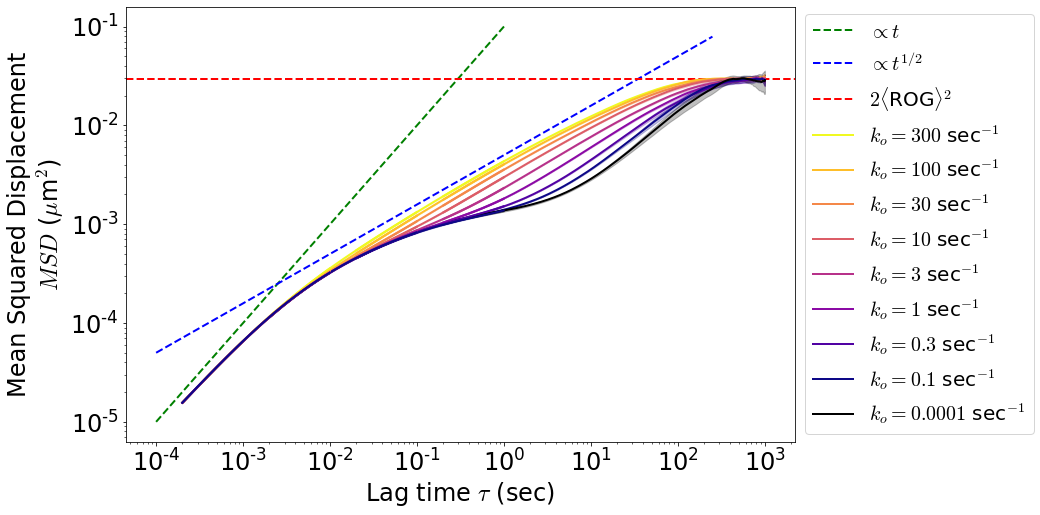

In [30]:
fig, axarr = plt.subplots(1,1, figsize=(12, 8))
# graph_msd_ax(fig, axarr, 
#              cond_path /"22-10-16_aLc1_line800_sticky55nm_kod.1-300/analysis/msd_run_data.h5", 
#              label_str="$k_o = ${}")
# Straight lines
time_arr = np.linspace(.0001, 1000, 2000)
_ = axarr.plot(time_arr[:3], .1*time_arr[:3], c='g', linestyle='--', label= "$\propto t$")
_ = axarr.plot(time_arr[:500], .005*np.sqrt(time_arr[:500]), c='b', linestyle='--', label= "$\propto t^{1/2}$")
# _ = axarr.plot(time_arr[2:350], .0004*np.power(time_arr[2:350],.6), c='g', linestyle='--', label= "$\propto t^{3/5}$")
# _ = axarr.plot(time_arr[:300], .001*np.power(time_arr[:300],.25), c='m', linestyle='--', label= "$\propto t^{1/4}$")
_, _, avg_rog, _ = get_param_stats(cond_path/"22-10-16_aLc1_line800_sticky55nm_kod.1-300/analysis/rog_run_data.h5")
_ = axarr.axhline(2*(avg_rog)**2, .0001, 1000, c='r', linestyle='--', label=r'$2\langle$ROG$\rangle^2$')


graph_msd_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/analysis/msd_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$")

# Make k_o = .0001 curve
make_single_graph_msd(fig, axarr, 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.1/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$",show_legend=True) 

make_single_graph_msd(fig, axarr, 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.01/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$", fend_cut_ind = -9900) 
make_single_graph_msd(fig, axarr, 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.001/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$", fend_cut_ind = -9900) 
make_single_graph_msd(fig, axarr, 
                      cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.0001/analysis/msd_run_data.h5", 
                      key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$", fend_cut_ind = -9900) 

# Make the rest of the graphs
graph_msd_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/analysis/msd_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=False, send_cut_ind = 2, fend_cut_ind = -9900)
graph_msd_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/analysis/msd_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=False, fend_cut_ind = -9900)
graph_msd_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/analysis/msd_run_data.h5", 
             label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=False, fend_cut_ind = -9900)

100
100
100
[0.000e+00 1.000e-04 2.000e-04 ... 9.997e+02 9.998e+02 9.999e+02]
tensor([        nan, -60710.4775, -30251.4799,  ...,  -8889.1002,
         -8889.0987,  -8889.0970], dtype=torch.float64)
tensor([       nan+nanj, 2.4246e+04-60710.4775j, 1.8504e+04-30251.4799j,
         ..., 8.2261e-03-8889.1002j, 5.7845e-03-8889.0987j,
        2.8747e-03-8889.0970j], dtype=torch.complex128)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


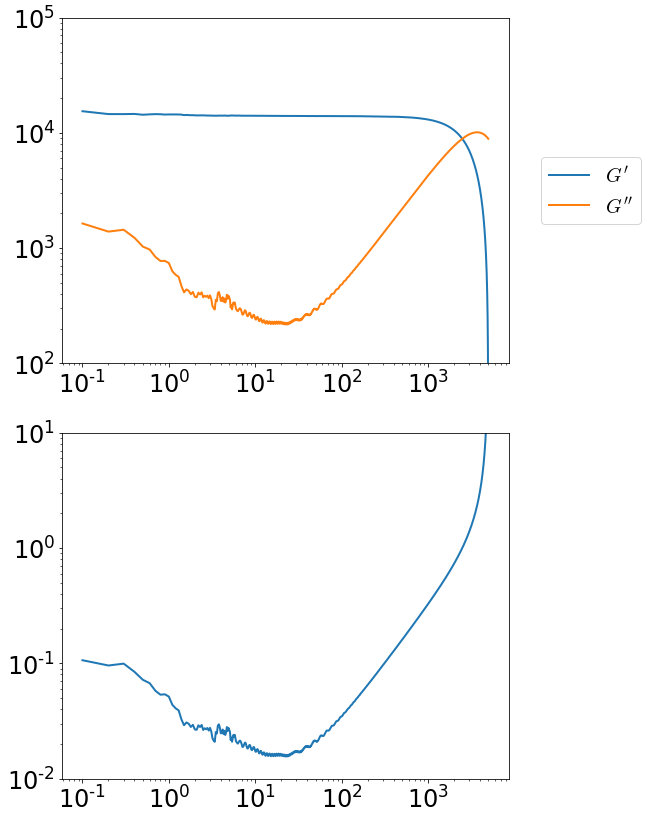

In [7]:
# fig, axarr = plt.subplots(1,1, figsize=(12, 8))
# graph_msd_ax(fig, axarr, 
#              cond_path /"22-10-16_aLc1_line800_sticky55nm_kod.1-300/analysis/msd_run_data.h5", 
#              label_str="$k_o = ${}")
# Straight lines
# time_arr = np.linspace(.0001, 1000, 2000)
# _ = axarr.plot(time_arr[:3], .1*time_arr[:3], c='g', linestyle='--', label= "$\propto t$")
# _ = axarr.plot(time_arr[:500], .005*np.sqrt(time_arr[:500]), c='b', linestyle='--', label= "$\propto t^{1/2}$")
# # _ = axarr.plot(time_arr[2:350], .0004*np.power(time_arr[2:350],.6), c='g', linestyle='--', label= "$\propto t^{3/5}$")
# # _ = axarr.plot(time_arr[:300], .001*np.power(time_arr[:300],.25), c='m', linestyle='--', label= "$\propto t^{1/4}$")
# _, _, avg_rog, _ = get_param_stats(cond_path/"22-10-16_aLc1_line800_sticky55nm_kod.1-300/analysis/rog_run_data.h5")
# _ = axarr.axhline(2*(avg_rog)**2, .0001, 1000, c='r', linestyle='--', label=r'$2\langle$ROG$\rangle^2$')

data_path_lst = [
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/analysis/msd_run_data.h5", 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/analysis/msd_run_data.h5",
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/analysis/msd_run_data.h5", 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/analysis/msd_run_data.h5", 
] 

# Make spline from data
ireg_time_arr = np.array([])
ireg_msd_arr = np.array([])
start_ind = 10
dt = .0001
kbt = .00411
diam = .02
for h5f in data_path_lst:
    with h5py.File(h5f, 'r') as h5d:
        new_time_arr = h5d['300'][:,0]
        new_msd_arr = h5d['300'][:,1]
        border_ind = None
        if ireg_time_arr.size != 0:
            border_ind = np.where(new_time_arr > ireg_time_arr[start_ind])[0][0]-1
            print(border_ind)
        ireg_time_arr = np.append(new_time_arr[:border_ind], ireg_time_arr[start_ind:])
        ireg_msd_arr = np.append(new_msd_arr[:border_ind], ireg_msd_arr[start_ind:])

print(ireg_time_arr)

time_arr = np.arange(ireg_time_arr[2], ireg_time_arr[-1], dt)
cb = CubicSpline(ireg_time_arr, ireg_msd_arr)

ft_msd = - torch.fft.fft(torch.from_numpy(cb(time_arr)), norm='forward')
n_modes = ft_msd.size()[0]
n_pos_vals = int(n_modes/2)
freq = torch.fft.fftfreq(n_modes, dt)[:n_pos_vals]

g_star = kbt / (diam*np.pi *1j* freq * ft_msd[:n_pos_vals])
print(g_star.imag) 

fig, axarr = plt.subplots(2,1, figsize=(8, 14))
n_skip = 100
print(g_star[:n_pos_vals])
# _ = axarr[0].plot(freq[::n_skip], ft_msd.real[:n_pos_vals:n_skip], label = "$G'$")
# _ = axarr[0].plot(freq[::n_skip], ft_msd.imag[:n_pos_vals:n_skip], label = "$G''$")
_ = axarr[0].plot(freq[::n_skip], torch.absolute(g_star.real[::n_skip]), label = "$G'$")
_ = axarr[0].plot(freq[::n_skip], torch.absolute(g_star.imag[::n_skip]), label="$G''$")
_ = axarr[1].plot(freq[::n_skip], torch.absolute(g_star.imag[::n_skip])/torch.absolute(g_star.real)[::n_skip], label="$G''$")

_ = axarr[0].legend(loc='center left', bbox_to_anchor=(1.05, .5))


# print(time_arr)


# _ = plt.plot(time_arr, cb(time_arr))

# _ = plt.scatter(time_arr, cb(time_arr))
# _ = plt.xlim(.001, 1000)

_ = axarr[0].set_ylim(100, 100000)
_ = axarr[1].set_ylim(.01, 10)
for ax in axarr:
    _ = ax.set_yscale('log')
    _ = ax.set_xscale('log')

# print(time_arr.size)
        

# graph_msd_ax(fig, axarr, 
#              cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/analysis/msd_run_data.h5", 
#              label_str="$k_o = {}$ sec$^{{-1}}$")

# make_single_graph_msd(fig, axarr, 
#                       cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.1/analysis/msd_run_data.h5", 
#                       key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$",show_legend=True) 

# make_single_graph_msd(fig, axarr, 
#                       cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.01/analysis/msd_run_data.h5", 
#                       key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$", fend_cut_ind = -9900) 
# make_single_graph_msd(fig, axarr, 
#                       cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.001/analysis/msd_run_data.h5", 
#                       key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$", fend_cut_ind = -9900) 
# make_single_graph_msd(fig, axarr, 
#                       cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.0001/analysis/msd_run_data.h5", 
#                       key='0.0001', label_str="$k_o = {}$ sec$^{{-1}}$", fend_cut_ind = -9900) 

# graph_msd_ax(fig, axarr, 
#              cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/analysis/msd_run_data.h5", 
#              label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=False, send_cut_ind = 2, fend_cut_ind = -9900)
# graph_msd_ax(fig, axarr, 
#              cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/analysis/msd_run_data.h5", 
#              label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=False, fend_cut_ind = -9900)
# graph_msd_ax(fig, axarr, 
#              cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/analysis/msd_run_data.h5", 
#              label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=False, fend_cut_ind = -9900)

In [1]:

def make_msd_spline(data_path_lst, key, dt=.0001, start_ind=10):
    ireg_time_arr = np.array([])
    ireg_msd_arr = np.array([])
    dt = .0001
    for h5f in data_path_lst:
        with h5py.File(h5f, 'r') as h5d:
            new_time_arr = h5d[key][:,0]
            new_msd_arr = h5d[key][:,1]
            border_ind = None
            if ireg_time_arr.size != 0:
                border_ind = np.where(new_time_arr > ireg_time_arr[start_ind])[0][0]-1
            ireg_time_arr = np.append(new_time_arr[:border_ind], ireg_time_arr[start_ind:])
            ireg_msd_arr = np.append(new_msd_arr[:border_ind], ireg_msd_arr[start_ind:])

    print(ireg_time_arr[-1])
    time_arr = np.arange(ireg_time_arr[2], ireg_time_arr[-1], dt)
    cb = interpolate.interp1d(ireg_time_arr, ireg_msd_arr)

    return time_arr, cb

data_path_lst = [
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/analysis/msd_run_data.h5", 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/analysis/msd_run_data.h5",
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/analysis/msd_run_data.h5", 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/analysis/msd_run_data.h5", 
] 

with h5py.File(data_path_lst[0], 'r') as h5d:
    param_vals = sorted(list(h5d.keys()), key=lambda x: float(x))
    log_pvs = np.log10([float(p)+.000001 for p in param_vals]) 
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = plb.cm.plasma(log_pvs)

fig, axarr = plt.subplots(3,1, figsize=(8, 12))
for k, c in zip(param_vals, colors):
    dt = .0001
    time_arr, cb = make_msd_spline(data_path_lst, k, dt)
    kbt = .00411
    diam = .02


    ft_msd = - torch.fft.fft(torch.from_numpy(cb(time_arr)), norm='forward')
    n_modes = ft_msd.size()[0]
    n_pos_vals = int(n_modes/2)
    freq = torch.fft.fftfreq(n_modes, dt)[:n_pos_vals]

    g_star = kbt / (diam*np.pi *1j* freq * ft_msd[:n_pos_vals])
    # print(g_star.imag) 

    n_skip = 100
    # print(g_star[:n_pos_vals])
    # _ = axarr[0].plot(freq[::n_skip], ft_msd.real[:n_pos_vals:n_skip], label = "$G'$")
    # _ = axarr[0].plot(freq[::n_skip], ft_msd.imag[:n_pos_vals:n_skip], label = "$G''$")
    # _ = axarr[0].plot(freq[::n_skip], torch.absolute(g_star.real[::n_skip]), label = "$G'$")
    _ = axarr[0].plot(freq[::n_skip], g_star.real[:n_pos_vals:n_skip], label = f'$k_{{o}}={k}$', color=c)
    _ = axarr[1].plot(freq[::n_skip], torch.absolute(g_star.imag[::n_skip]), label=f'$k_{{o}}={k}$ sec$^{{-1}}$', color=c)
    _ = axarr[2].plot(freq[::n_skip], torch.absolute(g_star.imag[::n_skip])/torch.absolute(g_star.real)[::n_skip], color=c)

_ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))


_ = axarr[0].set_ylabel("$G'$")
_ = axarr[1].set_ylabel("$G''$")
_ = axarr[2].set_ylabel(r"$\tan(\delta) = G''/G'$")

_ = axarr[0].set_ylim(1000, 20000)
_ = axarr[1].set_ylim(50, 50000)
_ = axarr[2].set_ylim(.005, 10)
_ = axarr[2].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
for ax in axarr:
    _ = ax.set_yscale('log')
    _ = ax.set_xscale('log')

# fig.tight_layout()


NameError: name 'cond_path' is not defined

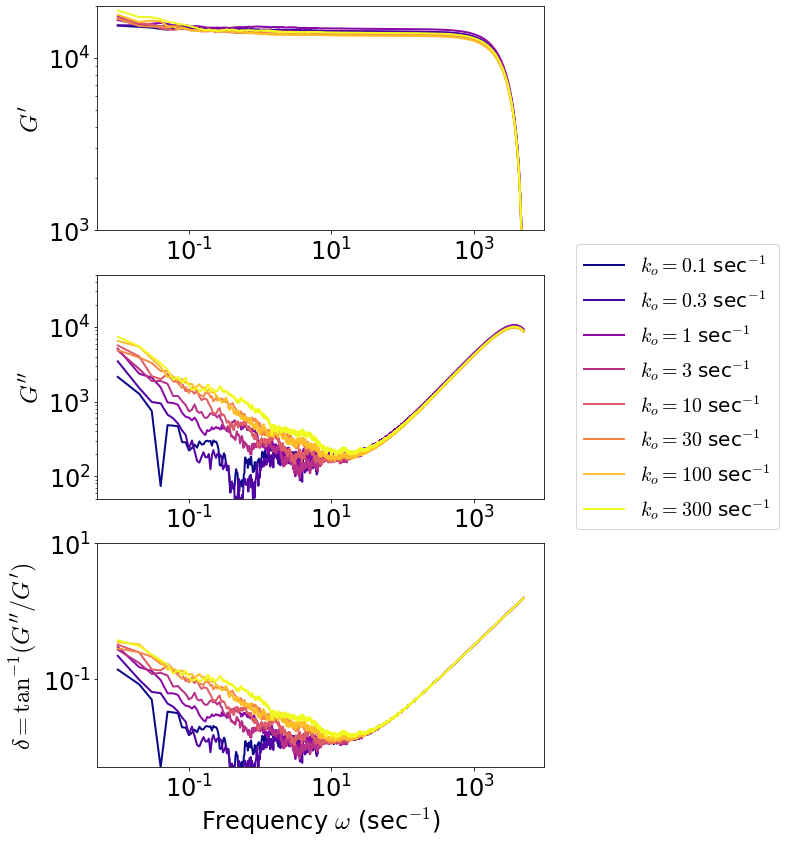

In [74]:

def make_msd_spline(data_path_lst, key, dt=.0001, start_ind=10):
    ireg_time_arr = np.array([])
    ireg_msd_arr = np.array([])
    dt = .0001
    for h5f in data_path_lst:
        with h5py.File(h5f, 'r') as h5d:
            new_time_arr = h5d[key][:,0]
            new_msd_arr = h5d[key][:,1]
            border_ind = None
            if ireg_time_arr.size != 0:
                border_ind = np.where(new_time_arr > ireg_time_arr[start_ind])[0][0]-1
            ireg_time_arr = np.append(new_time_arr[:border_ind], ireg_time_arr[start_ind:])
            ireg_msd_arr = np.append(new_msd_arr[:border_ind], ireg_msd_arr[start_ind:])

    time_arr = np.arange(ireg_time_arr[2], ireg_time_arr[-1], dt)
    cb = interpolate.interp1d(ireg_time_arr, ireg_msd_arr)

    return time_arr, cb

data_path_lst = [
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/analysis/msd_run_data.h5", 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/analysis/msd_run_data.h5",
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/analysis/msd_run_data.h5", 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/analysis/msd_run_data.h5", 
] 

with h5py.File(data_path_lst[0], 'r') as h5d:
    param_vals = sorted(list(h5d.keys()), key=lambda x: float(x))
    log_pvs = np.log10([float(p)+.000001 for p in param_vals]) 
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = plb.cm.plasma(log_pvs)

fig, axarr = plt.subplots(3,1, figsize=(8, 14))
for k, c in zip(param_vals, colors):
    dt = .0001
    time_arr, cb = make_msd_spline(data_path_lst, k, dt)
    kbt = .00411
    diam = .02


    ft_msd = - torch.fft.fft(torch.from_numpy(cb(time_arr)), norm='forward')
    n_modes = ft_msd.size()[0]
    n_pos_vals = int(n_modes/2)
    freq = torch.fft.fftfreq(n_modes, dt)[:n_pos_vals]

    g_star = kbt / (diam*np.pi *1j* freq * ft_msd[:n_pos_vals])
    # print(g_star.imag) 

    n_skip = 10
    # print(g_star[:n_pos_vals])
    # _ = axarr[0].plot(freq[::n_skip], ft_msd.real[:n_pos_vals:n_skip], label = "$G'$")
    # _ = axarr[0].plot(freq[::n_skip], ft_msd.imag[:n_pos_vals:n_skip], label = "$G''$")
    # _ = axarr[0].plot(freq[::n_skip], torch.absolute(g_star.real[::n_skip]), label = "$G'$")
    _ = axarr[0].plot(freq[::n_skip], g_star.real[:n_pos_vals:n_skip], label = f'$k_{{o}}={k}$', color=c)
    _ = axarr[1].plot(freq[::n_skip], torch.absolute(g_star.imag[::n_skip]), label=f'$k_{{o}}={k}$ sec$^{{-1}}$', color=c)
    _ = axarr[2].plot(freq[::n_skip], torch.arctan(torch.absolute(g_star.imag[::n_skip])/torch.absolute(g_star.real)[::n_skip]), color=c)

_ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))


_ = axarr[0].set_ylabel("$G'$")
_ = axarr[1].set_ylabel("$G''$")
_ = axarr[2].set_ylabel(r"$\delta = \tan^{-1}(G''/G')$")

_ = axarr[0].set_ylim(1000, 20000)
_ = axarr[1].set_ylim(50, 50000)
_ = axarr[2].set_ylim(.005, 10)
_ = axarr[2].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
for ax in axarr:
    _ = ax.set_yscale('log')
    _ = ax.set_xscale('log')
# _ = axarr[2].set_xscale('log')

# fig.tight_layout()


4999257

4999257

4999257

4999257

4999257

4999257

4999257

4999257

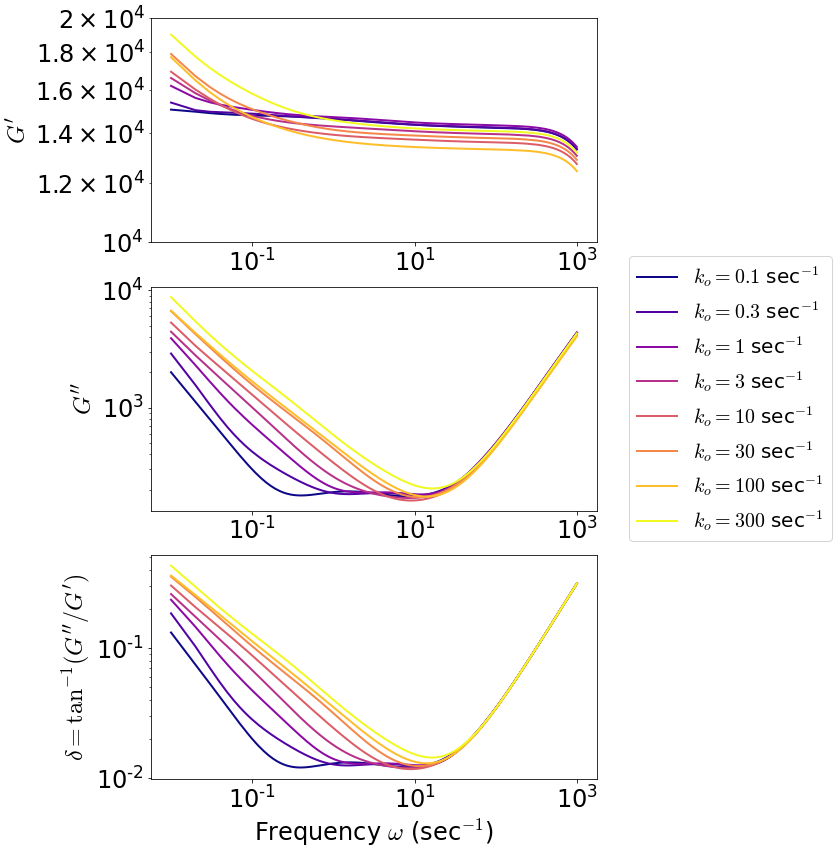

In [87]:

def make_log_chebfit(data_path_lst, key, dt=.0001, start_ind=10):
    ireg_time_arr = np.array([])
    ireg_msd_arr = np.array([])
    dt = .0001
    for h5f in data_path_lst:
        with h5py.File(h5f, 'r') as h5d:
            new_time_arr = h5d[key][:,0]
            new_msd_arr = h5d[key][:,1]
            border_ind = None
            if ireg_time_arr.size != 0:
                border_ind = np.where(new_time_arr > ireg_time_arr[start_ind])[0][0]-1
            ireg_time_arr = np.append(new_time_arr[:border_ind], ireg_time_arr[start_ind:])
            ireg_msd_arr = np.append(new_msd_arr[:border_ind], ireg_msd_arr[start_ind:])

    # Find logorithmic
    coefs= chebfit(np.log(ireg_time_arr[2:]), np.log(ireg_msd_arr[2:]), 15)
    time_arr = np.arange(np.log(ireg_time_arr[2]), np.log(ireg_time_arr[-1]), dt)
    # approx = chebval(time_arr, coefs)
    # cb = interpolate.interp1d(ireg_time_arr, ireg_msd_arr)

    return time_arr, coefs

data_path_lst = [
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/analysis/msd_run_data.h5", 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/analysis/msd_run_data.h5",
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/analysis/msd_run_data.h5", 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/analysis/msd_run_data.h5", 
] 

with h5py.File(data_path_lst[0], 'r') as h5d:
    param_vals = sorted(list(h5d.keys()), key=lambda x: float(x))
    log_pvs = np.log10([float(p)+.000001 for p in param_vals]) 
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = plb.cm.plasma(log_pvs)

fig, axarr = plt.subplots(3,1, figsize=(8, 14))
for k, c in zip(param_vals, colors):
    dt = .0001
    kbt = .00411
    diam = .02

    log_time_arr, coeff = make_log_chebfit(data_path_lst, k, dt)
    log_freqs = -log_time_arr
    # print(log_freqs)
    time_arr = np.arange(np.exp(log_time_arr[0]), np.exp(log_time_arr[-1]), dt)


    msd = np.exp(chebval(np.log(time_arr), coeff)) # evaluate MSD at proper frequencies



    ft_msd = - torch.fft.fft(torch.from_numpy(msd), norm='forward')
    n_modes = ft_msd.size()[0]
    n_pos_vals = int(n_modes/2)
    freq = torch.fft.fftfreq(n_modes, dt)[:n_pos_vals]

    g_star = kbt / (diam*np.pi *1j* freq * ft_msd[:n_pos_vals])
    # print(g_star.imag) 

    n_skip = 10
    freq.size(0)
    n_stop = -4000000
    # print(g_star[:n_pos_vals])
    # _ = axarr[0].plot(freq[::n_skip], ft_msd.real[:n_pos_vals:n_skip], label = "$G'$")
    # _ = axarr[0].plot(freq[::n_skip], ft_msd.imag[:n_pos_vals:n_skip], label = "$G''$")
    # _ = axarr[0].plot(freq[::n_skip], torch.absolute(g_star.real[::n_skip]), label = "$G'$")
    _ = axarr[0].plot(freq[:n_stop:n_skip], g_star.real[:n_stop:n_skip], label = f'$k_{{o}}={k}$', color=c)
    _ = axarr[1].plot(freq[:n_stop:n_skip], torch.absolute(g_star.imag[:n_stop:n_skip]), label=f'$k_{{o}}={k}$ sec$^{{-1}}$', color=c)
    _ = axarr[2].plot(freq[:n_stop:n_skip], torch.arctan(torch.absolute(g_star.imag[:n_stop:n_skip])/torch.absolute(g_star.real)[:n_stop:n_skip]), color=c)

_ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))


_ = axarr[0].set_ylabel("$G'$")
_ = axarr[1].set_ylabel("$G''$")
_ = axarr[2].set_ylabel(r"$\delta = \tan^{-1}(G''/G')$")

_ = axarr[0].set_ylim(10000, 20000)
# _ = axarr[1].set_ylim(50, 50000)
# _ = axarr[2].set_ylim(.005, 10)
_ = axarr[2].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
for ax in axarr:
    _ = ax.set_yscale('log')
    _ = ax.set_xscale('log')
# _ = axarr[2].set_xscale('log')

# fig.tight_layout()


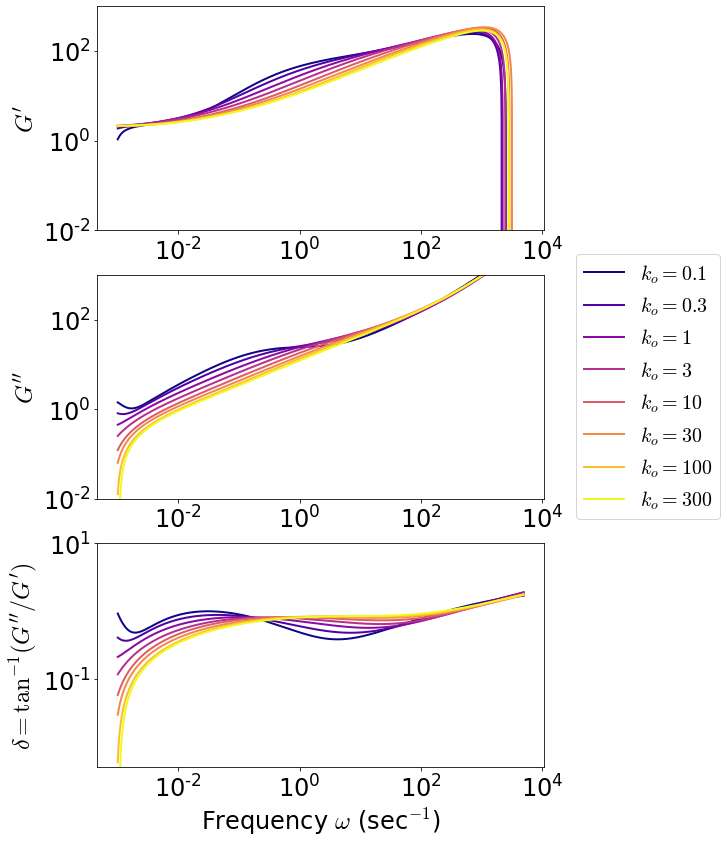

In [67]:

def make_log_chebfit(data_path_lst, key, dt=.0001, start_ind=10):
    ireg_time_arr = np.array([])
    ireg_msd_arr = np.array([])
    dt = .0001
    for h5f in data_path_lst:
        with h5py.File(h5f, 'r') as h5d:
            new_time_arr = h5d[key][:,0]
            new_msd_arr = h5d[key][:,1]
            border_ind = None
            if ireg_time_arr.size != 0:
                border_ind = np.where(new_time_arr > ireg_time_arr[start_ind])[0][0]-1
            ireg_time_arr = np.append(new_time_arr[:border_ind], ireg_time_arr[start_ind:])
            ireg_msd_arr = np.append(new_msd_arr[:border_ind], ireg_msd_arr[start_ind:])

    # Find logorithmic
    coefs= chebfit(np.log(ireg_time_arr[2:]), np.log(ireg_msd_arr[2:]), 5)
    time_arr = np.arange(np.log(ireg_time_arr[2]), np.log(ireg_time_arr[-1]), dt)
    # approx = chebval(time_arr, coefs)
    # cb = interpolate.interp1d(ireg_time_arr, ireg_msd_arr)

    return time_arr, coefs

def make_mason_approx(log_time_arr, cheb_coefs, kbt, diam):
    log_freqs = -log_time_arr
    # print(log_freqs)

    dev_coeff = cheb.chebder(cheb_coefs)
    alpha = chebval(log_time_arr, dev_coeff)
    # print(alpha)

    msd = np.exp(chebval(log_time_arr, cheb_coefs)) # evaluate MSD at proper frequencies

    gamma_fact = gamma(1.+ alpha)
    
    Gmag = kbt/(np.pi * diam * msd * gamma_fact)
    log_time_diff = np.diff(log_time_arr)
    delta = .5*np.pi*np.gradient(np.log(Gmag), log_time_diff[1])
    return log_freqs, Gmag, delta



data_path_lst = [
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/analysis/msd_run_data.h5", 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/analysis/msd_run_data.h5",
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/analysis/msd_run_data.h5", 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/analysis/msd_run_data.h5", 
] 

with h5py.File(data_path_lst[0], 'r') as h5d:
    param_vals = sorted(list(h5d.keys()), key=lambda x: float(x))
    log_pvs = np.log10([float(p)+.000001 for p in param_vals]) 
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = plb.cm.plasma(log_pvs)

fig, axarr = plt.subplots(3,1, figsize=(8, 14))
for k, c in zip(param_vals, colors):
    dt = .0001
    kbt = .00411
    diam = .02

    log_time_arr, coeff = make_log_chebfit(data_path_lst, k, dt)

    log_freq, Gmag, delta = make_mason_approx(log_time_arr, coeff, kbt, diam)
    _ = axarr[0].plot(np.exp(log_freq), Gmag*np.cos(delta), label = f'$k_{{o}}={k}$', color=c)
    _ = axarr[1].plot(np.exp(log_freq), Gmag*np.sin(-delta), label = f'$k_{{o}}={k}$', color=c)
    _ = axarr[2].plot(np.exp(log_freq), -delta, label = f'$k_{{o}}={k}$', color=c)

    # _ = axarr[0].plot(time_arr[::n_skip], cb[::n_skip], label = f'$k_{{o}}={k}$', color=c)


    # ft_msd = - torch.fft.fft(torch.from_numpy(cb(time_arr)), norm='forward')
    # n_modes = ft_msd.size()[0]
    # n_pos_vals = int(n_modes/2)
    # freq = torch.fft.fftfreq(n_modes, dt)[:n_pos_vals]

    # g_star = kbt / (diam*np.pi *1j* freq * ft_msd[:n_pos_vals])
    # # print(g_star.imag) 

    # n_skip = 100
    # # print(g_star[:n_pos_vals])
    # # _ = axarr[0].plot(freq[::n_skip], ft_msd.real[:n_pos_vals:n_skip], label = "$G'$")
    # # _ = axarr[0].plot(freq[::n_skip], ft_msd.imag[:n_pos_vals:n_skip], label = "$G''$")
    # # _ = axarr[0].plot(freq[::n_skip], torch.absolute(g_star.real[::n_skip]), label = "$G'$")
    # _ = axarr[0].plot(freq[::n_skip], g_star.real[:n_pos_vals:n_skip], label = f'$k_{{o}}={k}$', color=c)
    # _ = axarr[1].plot(freq[::n_skip], torch.absolute(g_star.imag[::n_skip]), label=f'$k_{{o}}={k}$ sec$^{{-1}}$', color=c)
    # _ = axarr[2].plot(freq[::n_skip], torch.arctan(torch.absolute(g_star.imag[::n_skip])/torch.absolute(g_star.real)[::n_skip]), color=c)

_ = axarr[1].legend(loc='center left', bbox_to_anchor=(1.05, .5))


_ = axarr[0].set_ylabel("$G'$")
_ = axarr[1].set_ylabel("$G''$")
_ = axarr[2].set_ylabel(r"$\delta = \tan^{-1}(G''/G')$")

_ = axarr[0].set_ylim(.01, 1000)
_ = axarr[1].set_ylim(.01, 1000)
_ = axarr[2].set_ylim(.005, 10)
_ = axarr[2].set_xlabel('Frequency $\omega$ (sec$^{-1}$)')
for ax in axarr:
    _ = ax.set_yscale('log')
    _ = ax.set_xscale('log')
# _ = axarr[2].set_xscale('log')

# fig.tight_layout()


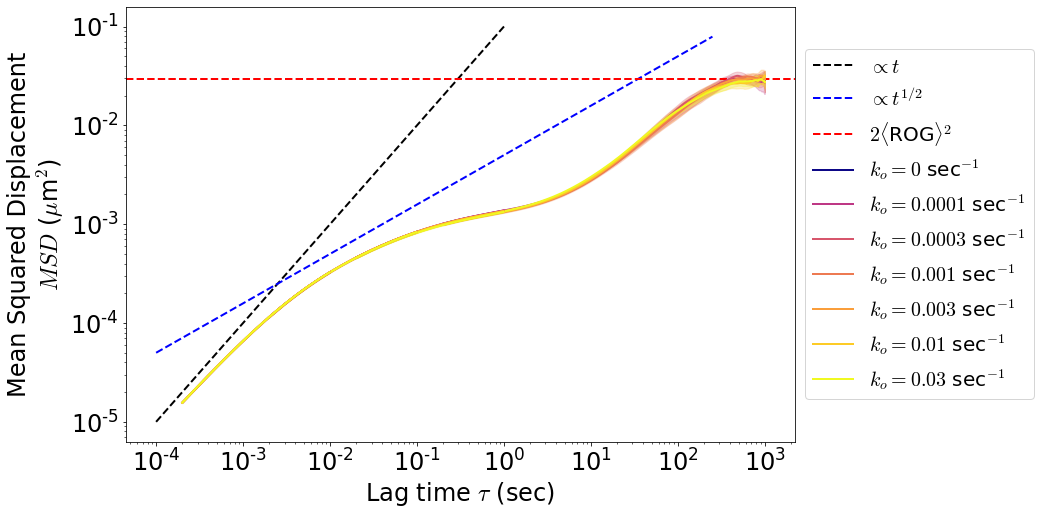

In [23]:
fig, axarr = plt.subplots(1,1, figsize=(12, 8))
# graph_msd_ax(fig, axarr, 
#              cond_path /"22-10-16_aLc1_line800_sticky55nm_kod.1-300/analysis/msd_run_data.h5", 
#              label_str="$k_o = ${}")
# Straight lines
time_arr = np.linspace(.0001, 1000, 2000)
_ = axarr.plot(time_arr[:3], .1*time_arr[:3], c='k', linestyle='--', label= "$\propto t$")
_ = axarr.plot(time_arr[:500], .005*np.sqrt(time_arr[:500]), c='b', linestyle='--', label= "$\propto t^{1/2}$")
_, _, avg_rog, _ = get_param_stats(cond_path/"22-10-16_aLc1_line800_sticky55nm_kod.1-300/analysis/rog_run_data.h5")
_ = axarr.axhline(2*(avg_rog)**2, .0001, 1000, c='r', linestyle='--', label=r'$2\langle$ROG$\rangle^2$')

graph_msd_ax(fig, axarr, 
             cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.1/analysis/msd_run_data.h5",
             label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=True)
graph_msd_ax(fig, axarr, 
             cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.01/analysis/msd_run_data.h5",
             label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=False, fend_cut_ind = -9900)
graph_msd_ax(fig, axarr, 
             cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.001/analysis/msd_run_data.h5",
             label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=False, fend_cut_ind = -9900)
graph_msd_ax(fig, axarr, 
             cond_path / "23-02-05_aLc1_line800_sticky55nm_kod0-.03_tsnap.0001/analysis/msd_run_data.h5",
             label_str="$k_o = {}$ sec$^{{-1}}$", show_legend=False, fend_cut_ind = -9900)

# Graphing

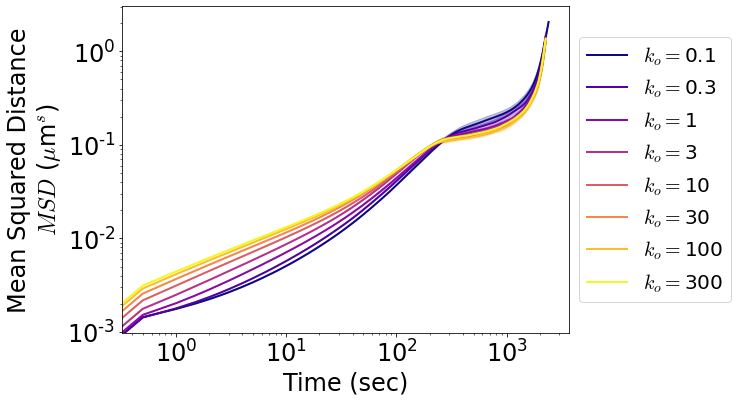

In [20]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
graph_msd_ax(fig, axarr, 
             cond_path /"22-10-16_aLc1_line800_sticky55nm_kod.1-300/analysis/msd_run_data.h5", 
             label_str="$k_o = ${}")

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


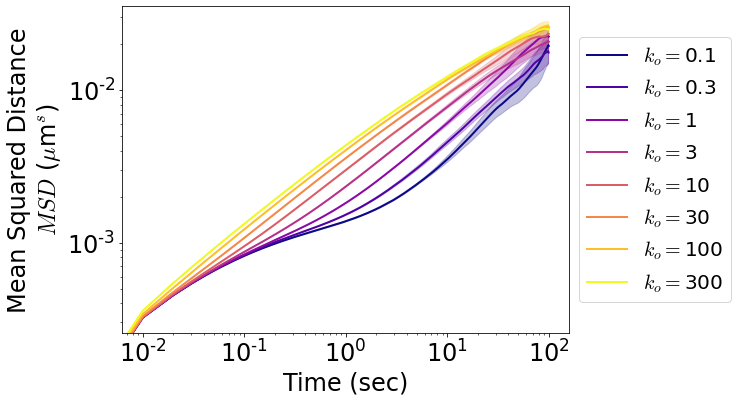

In [ ]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
graph_msd_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.01/analysis/msd_run_data.h5", 
             label_str="$k_o = ${}")

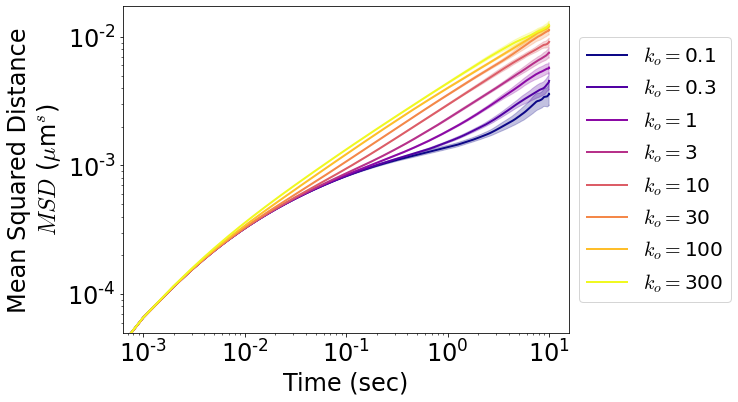

In [18]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
graph_msd_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.001/analysis/msd_run_data.h5", 
             label_str="$k_o = ${}")

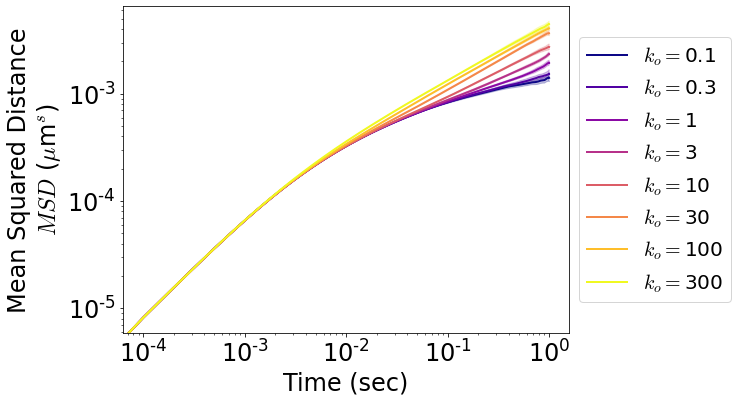

In [19]:
fig, axarr = plt.subplots(1,1, figsize=(8, 6))
graph_msd_ax(fig, axarr, 
             cond_path /"23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.0001/analysis/msd_run_data.h5", 
             label_str="$k_o = ${}")

# Figures